In [1]:
import sys
import numpy as np
sys.path.append("../")
from irradiance.models.kan_success import FastKANIrradiance
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

In [2]:
checkpoint_path = '/home/andres_munoz_j/megsai_results/kan_no_baseline.ckpt.ckpt'
eve_norm_path = '/mnt/disks/data-extended/preprocessed/EVE/EVS_MEGS-A_stats.npy'

eve_norm = np.load(eve_norm_path)

In [3]:
model_ckpt = torch.load(checkpoint_path)
model_ckpt

{'epochs': 100,
 'lr': 0.0001,
 'seed': 3110,
 'architecture': 'kan',
 'val_months': [2, 3],
 'test_months': [11, 12],
 'holdout_months': [1, 10],
 'ln_epochs': 50,
 'ln_lr': 0.01,
 'cnn_model': 'efficientnet_b3',
 'cnn_lr': 0.0001,
 'cnn_dp': 0.0,
 'cnn_epochs': 50,
 '94': [0],
 '131': [1],
 '171': [2],
 '193': [3],
 '211': [4],
 '304': [5],
 '335': [6],
 '1600': [7],
 '1700': [8],
 'AIA': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'EUVI': [2, 3, 4, 5],
 'EUI': [2, 5],
 'SUVI': [0, 1, 2, 3, 4, 5],
 'CIRCE': [1, 3, 5],
 'model': FastKANIrradiance(
   (loss_func): HuberLoss()
   (layers): ModuleList(
     (0): FastKANLayer(
       (layernorm): LayerNorm((18,), eps=1e-05, elementwise_affine=True)
       (rbf): RadialBasisFunction()
       (spline_linear): SplineLinear(in_features=144, out_features=1377, bias=False)
     )
   )
 ),
 'instrument': 'AIA'}

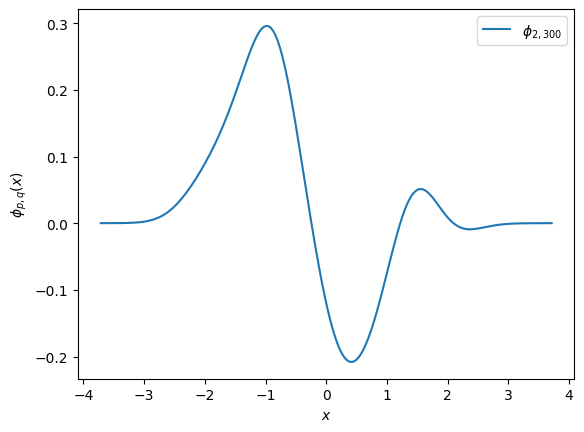

In [4]:
i=2
j=300
x, y = model_ckpt['model'].layers[0].plot_curve(i, j, 200, num_extrapolate_bins=3)
plt.plot(x.numpy(), y.numpy(), label=r"$\phi_{" + f"{i},{j}" + r"}$")
plt.xlabel("$x$")
plt.ylabel("$\phi_{p,q}(x)$")
plt.legend(loc="upper right")

Text(0.5, 0.42000000000000004, 'Channel 20')

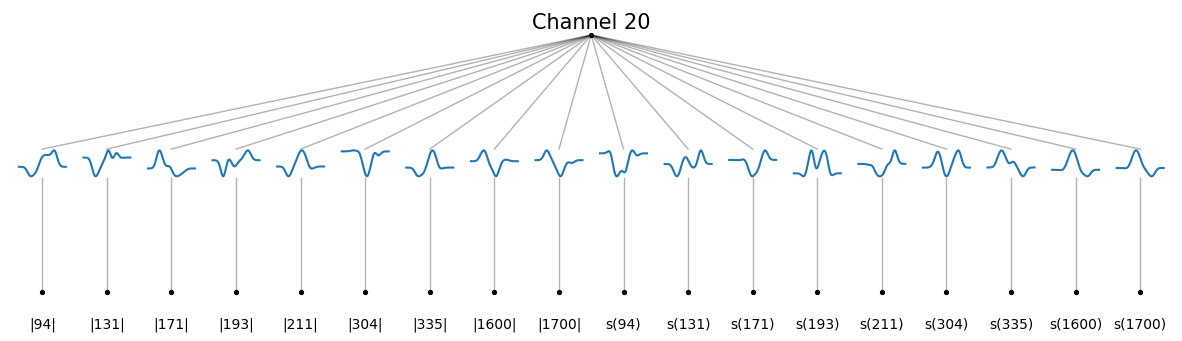

In [7]:
channel=20

A = 1
scale=0.5
neuron_depth = len(model_ckpt['model'].layers)+1
y0 = 0.4  # 0.4
mask=False

width = np.array([layer.input_dim for layer in model_ckpt['model'].layers]+[1])

min_spacing = A / np.maximum(np.max(width), 5)

max_num_weights = np.max(width)
y1 = 0.4 / np.maximum(max_num_weights, 3)

fig, ax = plt.subplots(figsize=(30 * scale, 10 * scale * (neuron_depth) * y0))


# plot scatters and lines
for l in range(neuron_depth):
    n = model_ckpt['model'].layers[l].input_dim if l < len(model_ckpt['model'].layers) else 1
    spacing = A / n
    for i in range(n):
        plt.scatter(1 / (2 * n) + i / n, l * y0, s=min_spacing ** 2 * 10000 * scale ** 2, color='black')

        if l < neuron_depth - 1:
            # plot connections
            n_next = width[l + 1]
            N = n * n_next
            for j in range(n_next):
                id_ = i * n_next + j
                color = "black"
                alpha_mask = .3

                if mask == True:
                    plt.plot([1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N], [l * y0, (l + 1 / 2) * y0 - y1], color=color, lw=2 * scale, alpha=alpha_mask)
                    plt.plot([1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next], [(l + 1 / 2) * y0 + y1, (l + 1) * y0], color=color, lw=2 * scale, alpha=alpha_mask)
                else:
                    plt.plot([1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N], [l * y0, (l + 1 / 2) * y0 - y1], color=color, lw=2 * scale, alpha=alpha_mask)
                    plt.plot([1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next], [(l + 1 / 2) * y0 + y1, (l + 1) * y0], color=color, lw=2 * scale, alpha=alpha_mask)

    plt.xlim(0, 1)
    plt.ylim(-0.1 * y0, (neuron_depth - 1 + 0.1) * y0)

plt.axis('off')

# -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# -- Take data coordinates and transform them to normalized figure coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

# plot splines
for l in range(neuron_depth - 1):
    n = width[l]
    for i in range(n):
        n_next = width[l + 1]
        N = n * n_next
        for j in range(n_next):
            id_ = i * n_next + j
            left = DC_to_NFC([1 / (2 * N) + id_ / N - y1, 0])[0]
            right = DC_to_NFC([1 / (2 * N) + id_ / N + y1, 0])[0]
            bottom = DC_to_NFC([0, (l + 1 / 2) * y0 - y1])[1]
            up = DC_to_NFC([0, (l + 1 / 2) * y0 + y1])[1]

            if l < len(model_ckpt['model'].layers):
                newax = fig.add_axes([left, bottom, right - left, up - bottom])
                # newax = fig.add_axes([1/(2*N)+id_/N-y1, (l+1/2)*y0-y1, y1, y1], anchor='NE')

                x, y = model_ckpt['model'].layers[l].plot_curve(i, channel, 200, num_extrapolate_bins=3)
                newax.plot(x.numpy(), y.numpy())

            newax.axis('off')


in_vars = ["|94|","|131|", "|171|", "|193|", "|211|", "|304|", "|335|", "|1600|", "|1700|", "s(94)","s(131)", "s(171)", "s(193)", "s(211)", "s(304)", "s(335)", "s(1600)", "s(1700)"]

n = model_ckpt['model'].layers[0].input_dim
for i in range(n):
    plt.gcf().get_axes()[0].text(1 / (2 * (n)) + i / (n), -0.05, in_vars[i], fontsize=20 * scale, horizontalalignment='center', verticalalignment='center')


title = f"Channel {channel}"
plt.gcf().get_axes()[0].text(0.5, y0 * (len(width) - 1) + 0.02, title, fontsize=30 * scale, horizontalalignment='center', verticalalignment='center')
